In [2]:
# !pip install --upgrade pandas-profiling==2.9.0
# !pip install pandas-profiling==3.4.0

In [1]:
!wget https://dagshub-public.s3.us-east-2.amazonaws.com/tutorials/stackexchange/CrossValidated-Questions-Nov-2020.csv -O CrossValidated-Questions.csv

--2023-07-04 11:12:11--  https://dagshub-public.s3.us-east-2.amazonaws.com/tutorials/stackexchange/CrossValidated-Questions-Nov-2020.csv
Resolving dagshub-public.s3.us-east-2.amazonaws.com (dagshub-public.s3.us-east-2.amazonaws.com)... 52.219.93.66
Connecting to dagshub-public.s3.us-east-2.amazonaws.com (dagshub-public.s3.us-east-2.amazonaws.com)|52.219.93.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75856988 (72M) [text/csv]
Saving to: ‘CrossValidated-Questions.csv’

CrossValidated-Ques 100%[===================>]  72.34M  3.16MB/s    in 43s     

2023-07-04 11:12:55 (1.68 MB/s) - ‘CrossValidated-Questions.csv’ saved [75856988/75856988]



In [2]:
!ls -lah

total 457824
drwxr-xr-x   6 kushalbanda  staff   192B Jun 30 12:09 .
drwxr-xr-x  10 kushalbanda  staff   320B Jun 30 10:41 ..
-rw-r--r--   1 kushalbanda  staff    72M Nov 10  2020 CrossValidated-Questions.csv
-rw-r--r--   1 kushalbanda  staff    23K Jul  4 11:12 DagsHub.ipynb
-rw-rw-r--   1 kushalbanda  staff    99M Jun 30 12:04 Questions.csv
-rw-r--r--   1 kushalbanda  staff    44M Jun 30 12:09 Questions.xlsx


### Load data for processing 

In [1]:
import pandas as pd 
df = pd.read_csv('CrossValidated-Questions.csv')
df

Id                                              Title  \
0      495508        Accepting null hypothesis given specificity   
1      495507  How do I calculate the probability of victory,...   
2      495506  Is joint modelling with survival and longitudi...   
3      495503    Are Spiking Neural Networks The Next Big Thing?   
4      495502  Public data and examples for practicing distri...   
...       ...                                                ...   
49995  371394  How to draw one standard deviation range aroun...   
49996  371389  Beta regression where fractional response adds...   
49997  371388  Proof of alternative parameterization of Weibu...   
49998  371386               A powerful test for any distribution   
49999  371383  Cox regression - non-time dependent continuous...   

                                                    Body  \
0      <p>In a population of 10000 people, there is a...   
1      <p>If I have a poll of 600 people (standard de...   
2      <p>I would like to know if joint models for su...   
3      <p>Intel recently announced their Loihi chip a...   
4      <p>Are there public data for practicing distri...   
...                                                  ...   
49995  <p>I have a distribution of data with a positi...   
49996  <p>I have a data set of people switching brand...   
49997  <p>In Parametric Survival Models by German Rod...   
49998  <p>Simulations by Razali et al (2011) showed t...   
49999  <p>I have this model I want to run that has no...   

                                                    Tags         CreationDate  \
0                                    <bayesian><p-value>  2020-11-08 03:59:02   
1      <probability><normal-distribution><t-distribut...  2020-11-08 02:09:11   
2                                 <survival><panel-data>  2020-11-08 01:55:08   
3      <machine-learning><neural-networks><sparse><ar...  2020-11-08 00:37:13   
4                                 <references><learning>  2020-11-08 00:09:25   
...                                                  ...                  ...   
49995  <distributions><mathematical-statistics><mean>...  2018-10-11 18:36:02   
49996                      <proportion><beta-regression>  2018-10-11 17:55:19   
49997      <survival><weibull><exponential-distribution>  2018-10-11 17:51:32   
49998  <hypothesis-testing><goodness-of-fit><normalit...  2018-10-11 17:39:16   
49999     <r><survival><cox-model><proportional-hazards>  2018-10-11 17:29:12   

       Score  ViewCount  AnswerCount  CommentCount  FavoriteCount  
0          0          5            0             2            NaN  
1          0         20            0             0            NaN  
2          0          5            0             0            NaN  
3          0         18            0             4            NaN  
4          1         10            0             3            1.0  
...      ...        ...          ...           ...            ...  
49995      0         52            1             3            NaN  
49996      2         97            0             2            1.0  
49997      2        178            0             1            NaN  
49998      1        111            1             4            NaN  
49999      0         81            1             3            NaN  

[50000 rows x 10 columns]

The columns are pretty self explanatory - we have:
* Two textual features (Title & Body).
We can already tell that this text is actually full of HTML tags, which we will probably need to clean to get good results.
* One string column that is actually the list of Tags for this question. This contains the target machine-learning tag we want to predict.
* Some numeric features: Score, ViewCount, AnswerCount, CommentCount, FavoriteCount
* One CreationDate feature that needs to be processed correctly:

In [2]:
df['CreationDate'] = pd.to_datetime(df['CreationDate'])
# Also include the numeric representation of the timestep, so we can look at its distribution / correlation with other features
df['CreationDate_Epoch']  = df['CreationDate'].astype('int64') // 10 ** 9

Also, remember the our end goal here is to classify questions about Machine Learning. This information is stored in the Tags column:

In [6]:
df['MachineLearning'] = df['Tags'].str.contains('machine-learning').fillna(False)

Now we can drop the non-informative columns

In [7]:
df = df.drop(columns = ['Id', 'Tags'])

Some positive and negative samples:

In [10]:
df[df['MachineLearning']].sample(5)

Title  \
43796                Does this mean my model is useless?   
3218   Why is ReLU so popular despite being NOT zero-...   
41871  Do I need a validation set if I am doing 10-fo...   
49139  What to conclude for the data-set when the var...   
35492  How to deal with the categorical variables wit...   

                                                    Body        CreationDate  \
43796  <p>Long story short, I have a random forest I'... 2019-02-05 22:22:58   
3218   <p>Activation functions should be zero-centere... 2020-09-26 18:24:58   
41871  <p>I am looking at a dataset with ~120 observa... 2019-03-07 21:40:26   
49139  <p>I am working on analysing and visualizing a... 2018-10-29 13:39:36   
35492  <p>The image below shows how the rating for th... 2019-06-28 02:26:43   

       Score  ViewCount  AnswerCount  CommentCount  FavoriteCount  \
43796      0         24            0             2            NaN   
3218       4         89            1             0            2.0   
41871      3        132            2             0            NaN   
49139      0        165            1             6            NaN   
35492      1         42            1             0            NaN   

       CreationDate_Epoch  MachineLearning  
43796          1549405378             True  
3218           1601144698             True  
41871          1551994826             True  
49139          1540820376             True  
35492          1561688803             True

In [11]:
df[df['MachineLearning'] != True].sample(5)

Title  \
30009  Unusual DV Odds Ratio for multiple Binary Logi...   
24175  Sample size for uniform multinomial to control...   
14778  Keeping an insignificant control variable (wit...   
34402  In a regression to estimate propensity score, ...   
22118          How to fit a MA(q) model for forecasting?   

                                                    Body        CreationDate  \
30009  <p>I am attempting to diagnose issues with the... 2019-10-15 18:20:07   
24175  <p>I'm interested in controlling the minimum f... 2020-01-15 15:26:26   
14778  <p>I am running a FE regression with state-lev... 2020-05-05 21:20:19   
34402  <p>I have a set of 88 people undergoing a trea... 2019-07-19 09:51:56   
22118  <p>I have some trouble with understanding how ... 2020-02-11 16:55:10   

       Score  ViewCount  AnswerCount  CommentCount  FavoriteCount  \
30009      1         42            0             0            NaN   
24175      0          7            0             0            NaN   
14778      1         11            0             0            NaN   
34402      1         19            0             0            NaN   
22118      1         65            0             1            NaN   

       CreationDate_Epoch  MachineLearning  
30009          1571163607            False  
24175          1579101986            False  
14778          1588713619            False  
34402          1563529916            False  
22118          1581440110            False

We can define a new Title_Len and Body_Len column to get interesting statistics on question length

In [12]:
df['Title_Len'] = df.Title.str.len()
df['Body_Len'] = df.Body.str.len()

### Data Exploration
Now, lets try to get a sense of data distribution. We start out with a sample pandas describe on all columns.

In [13]:
df.describe(include = 'all')

/var/folders/_9/wkm0tqns0n53w3ytpgc_68kc0000gn/T/ipykernel_5911/4220128335.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include = 'all')


Title  \
count                                             50000   
unique                                            49972   
top     K means clusters, would PCA be a better option?   
freq                                                  2   
first                                               NaN   
last                                                NaN   
mean                                                NaN   
std                                                 NaN   
min                                                 NaN   
25%                                                 NaN   
50%                                                 NaN   
75%                                                 NaN   
max                                                 NaN   

                                                     Body  \
count                                               50000   
unique                                              49987   
top     <p>Here is the link to the boy or girl paradox...   
freq                                                    2   
first                                                 NaN   
last                                                  NaN   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

               CreationDate         Score     ViewCount  AnswerCount  \
count                 50000  50000.000000  50000.000000  50000.00000   
unique                49974           NaN           NaN          NaN   
top     2018-11-07 11:05:52           NaN           NaN          NaN   
freq                      2           NaN           NaN          NaN   
first   2018-10-11 17:29:12           NaN           NaN          NaN   
last    2020-11-08 03:59:02           NaN           NaN          NaN   
mean                    NaN      1.121240    154.553100      0.67778   
std                     NaN      2.313259    616.019487      0.80392   
min                     NaN    -14.000000      1.000000      0.00000   
25%                     NaN      0.000000     23.000000      0.00000   
50%                     NaN      1.000000     42.000000      1.00000   
75%                     NaN      1.000000     97.000000      1.00000   
max                     NaN     87.000000  48969.000000     32.00000   

        CommentCount  FavoriteCount  CreationDate_Epoch MachineLearning  \
count   50000.000000    8918.000000        5.000000e+04           50000   
unique           NaN            NaN                 NaN               2   
top              NaN            NaN                 NaN           False   
freq             NaN            NaN                 NaN           44448   
first            NaN            NaN                 NaN             NaN   
last             NaN            NaN                 NaN             NaN   
mean        1.782800       1.366450        1.575066e+09             NaN   
std         2.551077       2.199443        1.878285e+07             NaN   
min         0.000000       0.000000        1.539279e+09             NaN   
25%         0.000000       1.000000        1.558326e+09             NaN   
50%         1.000000       1.000000        1.578066e+09             NaN   
75%         3.000000       1.000000        1.590782e+09             NaN   
max        34.000000      82.000000        1.604808e+09             NaN   

           Title_Len     Body_Len  
count   50000.000000  50000.00000  
unique           NaN          NaN  
top              NaN          NaN  
freq             NaN          NaN  
first            NaN          NaN  
last             NaN          NaN  
mean       63.073700   1336.45880  
std        25.075001

In [15]:
df.isnull().sum() * 100 / df.shape[0]

Title                  0.000
Body                   0.000
CreationDate           0.000
Score                  0.000
ViewCount              0.000
AnswerCount            0.000
CommentCount           0.000
FavoriteCount         82.164
CreationDate_Epoch     0.000
MachineLearning        0.000
Title_Len              0.000
Body_Len               0.000
dtype: float64

In [16]:
import seaborn as sns
sns.set()

11.104 % Labeled True


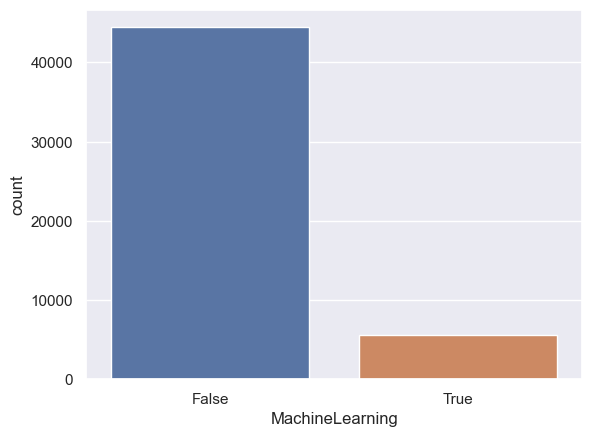

In [18]:
sns.countplot(x = "MachineLearning", data = df)
print(f"{df['MachineLearning'].mean() * 100} % Labeled True")

To quickly get a feel for the distribution of data, we can use pandas-profiling.
Note that the output is long and scrollable, so be sure to scroll through.
Some quick observations from this report are:

* We should drop the FavoriteCount column, since it's highly correlated with Score
Score, ViewCount, AnswerCount are highly skewed, so we might take that into account in data preparation.
* Our label MachineLearning is not too strongly related with any other single feature
* The CreationDate field is negatively correlated with most numeric fields, which would make sense as newer questions haven't had as much time to gather views, upvotes and answers.
* Body_Len is negatively correlated with AnswerCount, which also makes sense - people are probably less inclined to read through a long question before answering it
* There are probably many other things to learn from this report, but we'll leave it for now. In the next part of the tutorial, we'll use what we've learned about the data to process it for training models.

In [19]:
from pandas_profiling import ProfileReport
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
# Drop the correlated features
df = df.drop(columns = ["FavoriteCount"])

### Processing the data
First things first - we should split the data into train and test sets.
Even before training the model itself, the preprocessing stages are supposed to fit only the training data, not the test data.

In [21]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df)

Here, we try to scale and transform the numeric features to make them smoother, less skewed, and more appropriate for modeling.

PowerTransformer attempts to make the data more like a normal distribution, which should soften the impact of extreme outliers and make the distributions smoother.

MinMaxScaler is used as a first step to make sure the numbers are in a reasonable range, as PowerTransformer can fail on very large numbers.

In [22]:
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(MinMaxScaler(), PowerTransformer())
numeric_col_names = ['Title_Len', 'Body_Len', 'CreationDate_Epoch', 'AnswerCount', 'ViewCount', 'Score', 'CommentCount']
train_df_norm = pd.DataFrame(pipeline.fit_transform(train_df[numeric_col_names]), columns = numeric_col_names)
train_df_norm = train_df_norm.combine_first(train_df.reset_index()) # Add the other columns back

In [23]:
test_df_norm = pd.DataFrame(pipeline.transform(test_df[numeric_col_names]), columns = numeric_col_names)
test_df_norm = test_df_norm.combine_first(test_df.reset_index()) # Add the other columns back

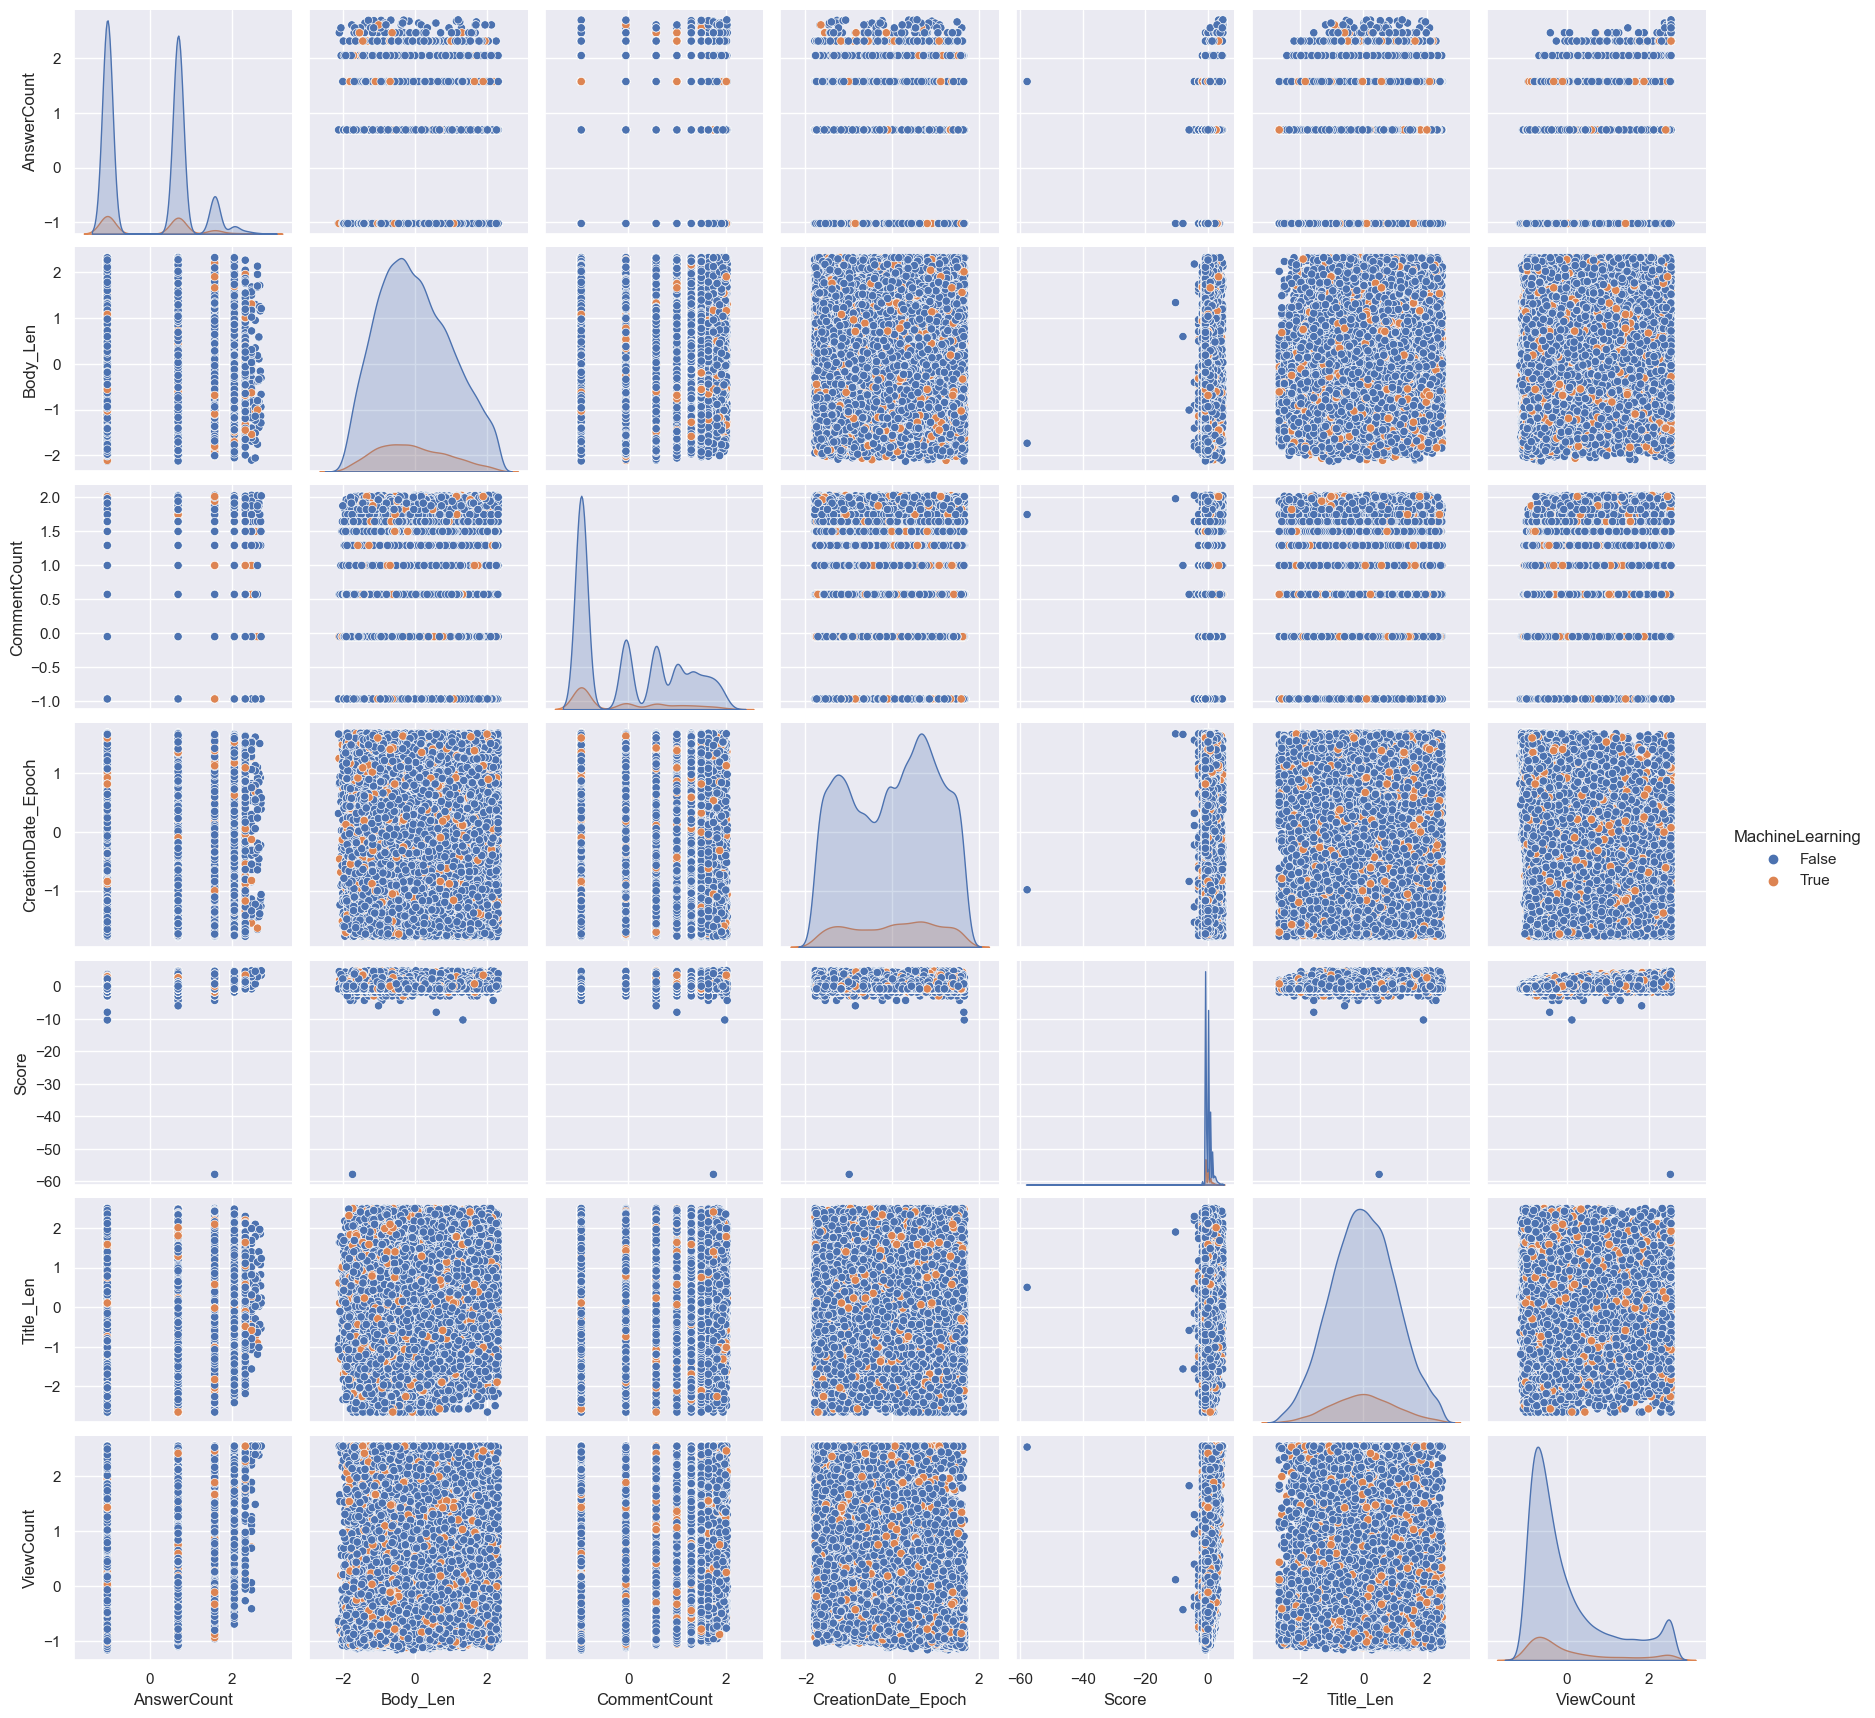

In [24]:
sns.pairplot(train_df_norm.drop(columns = ['index', 'CreationDate']), hue = 'MachineLearning')

### Model training
Now, we'll fit a basic Logistic Regression model to our data, to see that it manages to learn anything. We're not trying to optimize it yet, just see that it successfully learns something useful, and that our preparation of the data helped.

For the time being, we'll only use the numeric columns for this model. The textual columns require specialized preprocessing before they can be used as input to a model.

We'll drop the CreationDate column, as its information is already stored in the scaled CreationDate_Epoch column.

To get a good idea of how well the model learned something useful about the data, we also reserve some of the data for testing.

In [50]:
import sklearn.linear_model
clf = sklearn.linear_model.LogisticRegression()
train_cols = [c for c in numeric_col_names if c != 'CreationDate']


x = train_df_norm[train_cols]
y = train_df_norm['MachineLearning']
clf.fit(x , y)

LogisticRegression()

### Evaluation
Since we know that the classes are very imbalanced (only about 8% of the questions labeled as machine-learning), we'll avoid using the accuracy metric as an indication. Instead, we'll take a look at the precision-recall curve and ROC, which can tell us more useful information.

In [51]:
import sklearn.metrics
X_test = test_df_norm[train_cols]
y_test = test_df_norm['MachineLearning']

In [72]:
y_pred = clf.decision_function(X_test)

In [73]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc


def plot_precision_recall_curve(y_test, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    plt.plot(recall, precision, label = 'Precision Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()


def plot_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr) 
    
    plt.plot(fpr, tpr, label='AUC-ROC Curve (AUC = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    


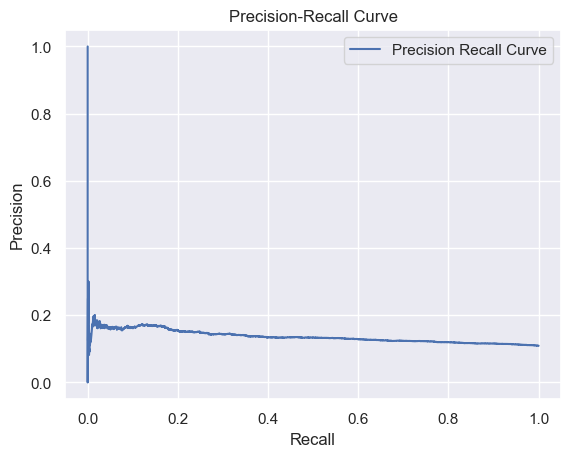

In [74]:
plot_precision_recall_curve(y_test, y_pred)

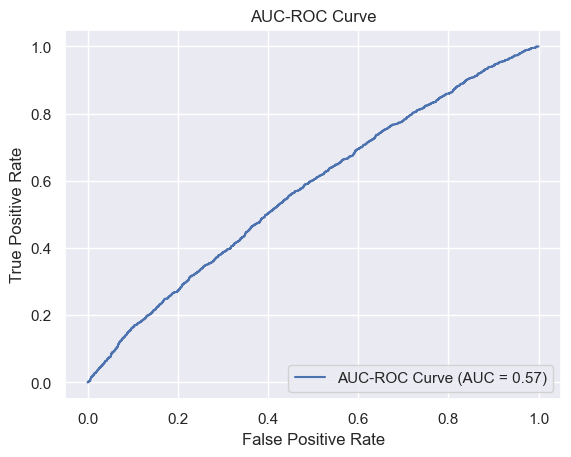

In [75]:
plot_roc_curve(y_test, y_pred)

We can also look at the learned feature importances to understand what our model is looking for:

<AxesSubplot:>

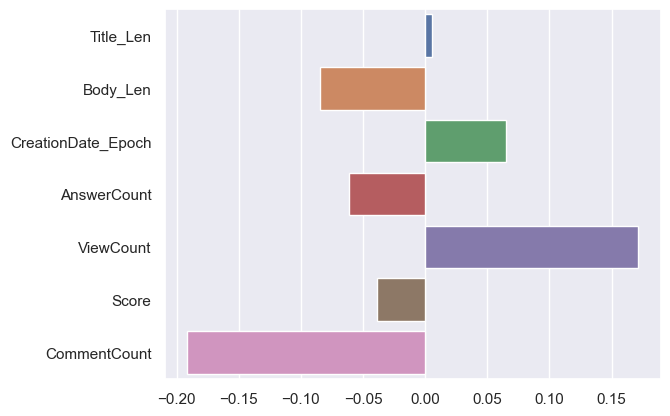

In [76]:
sns.barplot(y = train_cols, x = clf.coef_[0])

In [82]:
clf_raw = sklearn.linear_model.LogisticRegression()
X_raw = train_df[train_cols]
y_raw = train_df['MachineLearning']
clf_raw.fit(X_raw, y_raw)

X_test_raw = test_df[train_cols]
y_test_raw = test_df['MachineLearning']

In [83]:
y_pred_raw = clf_raw.decision_function(X_test_raw)
y_pred_raw

array([-2.07493162, -2.10916024, -2.08535453, ..., -2.06621145,
       -2.06672641, -2.04567519])

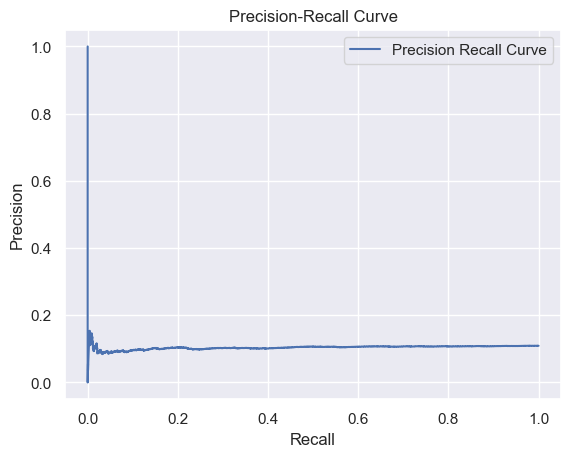

In [84]:
plot_precision_recall_curve(y_test_raw, y_pred_raw)

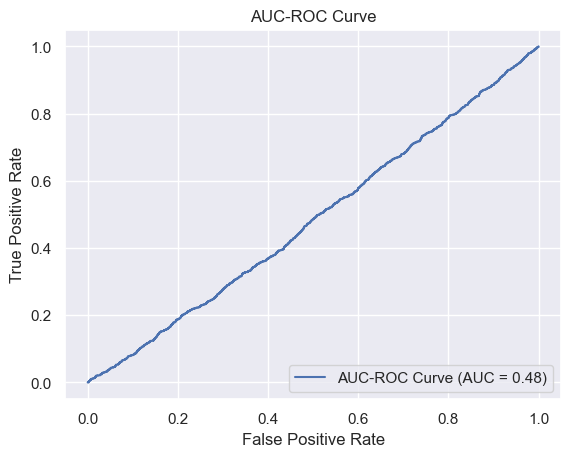

In [85]:
plot_roc_curve(y_test_raw, y_pred_raw)

### Textual Features
So, at this point we have a sense for our data, have found a good way to scale and normalze our numeric features, and have trained a very basic classifier on it.

The next phase would be to see what happens when we take advantage of our textual features - Title & Body. We'll use only the textual features to simplify things and isolate the effects.

To make things simple, we'll unify them into one big textual column.

In [86]:
train_text_col = train_df_norm['Title'].fillna('') + ' ' + train_df_norm['Body'].fillna('')
test_text_col = test_df_norm['Title'].fillna('') + ' ' + test_df_norm['Body'].fillna('')

To turn this text into numerical features that can be used as input to a ML model, we'll use [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) with a sensible limit of vocabulary size (`max_features=25000`). It will split the text into tokens, and give each question in the data a numerical representation of the frequency of tokens in that question.

Note that special care is needed when handling [sparse matrices in Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html), and the result returned from `TfidfVectorizer` is a sparse matrix. **If you ignore this special handling, expect to run into out-of-memory errors, unresponsiveness and crashes as the sparse matrix gets inflated.**

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=25000)
tfidf.fit(train_text_col)
train_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(train_text_col), columns=tfidf.get_feature_names_out())
test_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(test_text_col), columns=tfidf.get_feature_names_out())

**Interesting notes:** Looks like many of the learned terms are: 
* Various numbers, like `00`, `00000000e` etc. It could be useful to prevent this splitting of numbers into many different terms in the vocabulary, since it probably won't matter to classifying the text.
* Multiple terms grouped together due to an underscore, like `variable_2`. This is probably an artifact of embedded Python or TeX code. It might help the model if we break these down to separate terms.
* Remember, the questions contain embedded HTML. While we're not seeing any terms that were clearly garbage created by HTML, it's a good bet that it will be useful to clean up the HTML tags in the text.

In [97]:
train_tfidf_df.sample(15, axis = 1)

333333333333333  esp  0196  preds  crossbasis  ignorance  specifying  \
0                  0.0  0.0   0.0    0.0         0.0        0.0         0.0   
1                  0.0  0.0   0.0    0.0         0.0        0.0         0.0   
2                  0.0  0.0   0.0    0.0         0.0        0.0         0.0   
3                  0.0  0.0   0.0    0.0         0.0        0.0         0.0   
4                  0.0  0.0   0.0    0.0         0.0        0.0         0.0   
...                ...  ...   ...    ...         ...        ...         ...   
37495              0.0  0.0   0.0    0.0         0.0        0.0         0.0   
37496              0.0  0.0   0.0    0.0         0.0        0.0         0.0   
37497              0.0  0.0   0.0    0.0         0.0        0.0         0.0   
37498              0.0  0.0   0.0    0.0         0.0        0.0         0.0   
37499              0.0  0.0   0.0    0.0         0.0        0.0         0.0   

       yearly  token       and  covs  bigger  srmr  np_i  popularity  
0         0.0    0.0  0.043700   0.0     0.0   0.0   0.0         0.0  
1         0.0    0.0  0.054951   0.0     0.0   0.0   0.0         0.0  
2         0.0    0.0  0.054875   0.0     0.0   0.0   0.0         0.0  
3         0.0    0.0  0.015785   0.0     0.0   0.0   0.0         0.0  
4         0.0    0.0  0.031602   0.0     0.0   0.0   0.0         0.0  
...       ...    ...       ...   ...     ...   ...   ...         ...  
37495     0.0    0.0  0.032503   0.0     0.0   0.0   0.0         0.0  
37496     0.0    0.0  0.079429   0.0     0.0   0.0   0.0         0.0  
37497     0.0    0.0  0.070233   0.0     0.0   0.0   0.0         0.0  
37498     0.0    0.0  0.019910   0.0     0.0   0.0   0.0         0.0  
37499     0.0    0.0  0.000000   0.0     0.0   0.0   0.0         0.0  

[37500 rows x 15 columns]

In [98]:
clf_tfidf = sklearn.linear_model.LogisticRegression()
clf_tfidf.fit(train_tfidf_df.sparse.to_coo(), y)

/Users/kushalbanda/Anaconda/anaconda3/envs/MLOPS/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## Evaluating the textual model
Below, we can see that the new text-based model performs stunningly well!

This is not surprising, as most information will be contained in the text content of each question.

In [104]:
X_tfidf_test = test_tfidf_df.sparse.to_coo()
y_tfidf_pred = clf_tfidf.decision_function(X_tfidf_test)
# plot_precision_recall_curve(X_tfidf_test, y_test)
# plot_roc_curve(X_tfidf_test, y_test)

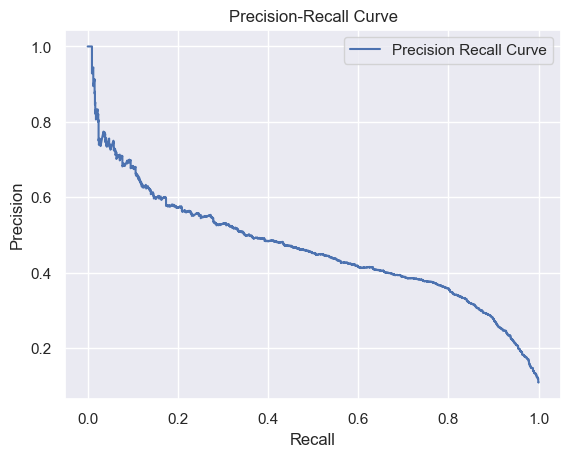

In [106]:
plot_precision_recall_curve(y_test, y_tfidf_pred)

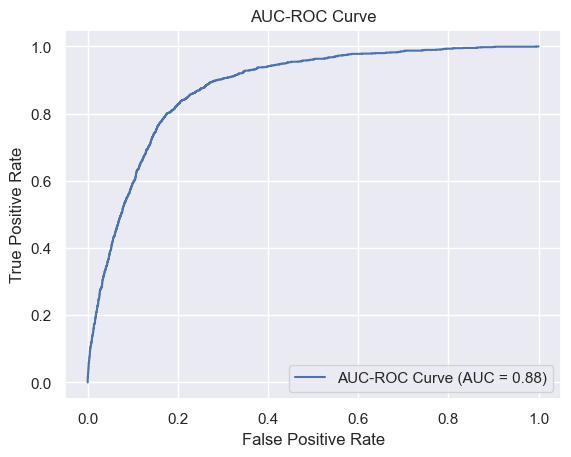

In [107]:
plot_roc_curve(y_test, y_tfidf_pred)

As a sanity check, it's a good idea to check what terms the textual model cares about when making its decision.

As we see below, it looks like our model learned some very good, sensible terms, that we would have probably guessed on our own, such as `machine`, `learning`, `classifier`, etc.

It's interesting to note that `analysis` is a *negative*  predictor for a question about machine learning, as opposed to a general statistical question. Just throw a neural network at it 😅

<AxesSubplot:xlabel='coef', ylabel='term'>

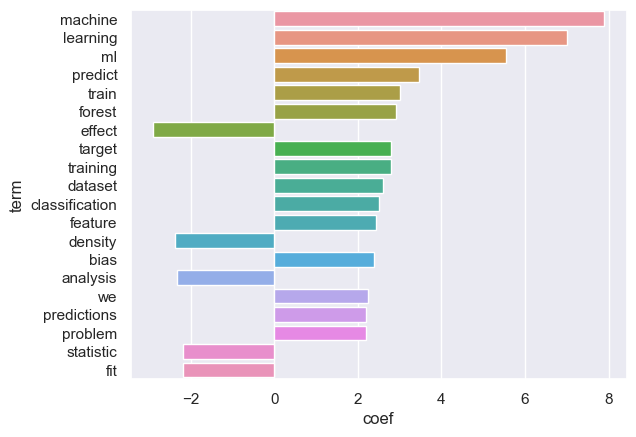

In [109]:
tfidf_coef_df = pd.DataFrame({'coef':clf_tfidf.coef_[0]})
tfidf_coef_df['term'] = tfidf.get_feature_names_out()
tfidf_coef_df['coef_abs'] = tfidf_coef_df['coef'].abs()
tfidf_coef_df = tfidf_coef_df.sort_values('coef_abs', ascending=False)
sns.barplot(y='term', x='coef', data=tfidf_coef_df[:20])

# Conclusion

We got a good sense of our data, the type of preprocessing required, and managed to train some decent classifiers with it.

At this point in a Python data science project, it's common to take the conclusions and working code from the exploratory notebook, and turn them into normal Python modules. This enables us to more easily:
* Create reusable components that will be useful as the project matures.
* Use code versioning tools like Git.
* Make the process more reproducible by defining a clear pipeline (order of operations) for the data and model training.
* Automate running and tracking of experiments.
* Version our different experiments and models, so that we preserve knowledge and don't risk losing work by accident.

[In the next level of DAGsHub's tutorial](https://dagshub.com/docs/experiment-tutorial/1-setup/), we'll take what works from this notebook and turn it into a Python project, before [going forward with experimentation](https://dagshub.com/docs/experiment-tutorial/2-experiments/) to find the best performing model for out problem.

Made with 🐶 by [DAGsHub](https://dagshub.com).